In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import os
import meep as mp
import meep.adjoint as mpa

In [2]:
his = np.load("data/eval_history.npy")
str = np.load("data/final_design.npy")
# gra = np.load("data/grad_history.npy")

In [3]:
Air = mp.Medium(index=1)
Si = mp.Medium(index=3.48)
resolution = 250

dx = 2.4  # design_region_x_width = 1    
dy = 0.8  # design_region_y_width = 1   
pml_size = 0.8
air_size = 0.3
Sx = dx + 2*pml_size
Sy = dy + 2*pml_size + 2*air_size
cell_size = mp.Vector3(Sx, Sy)
# ===  ===
Nx = int(dx * resolution) + 1 
Ny = int(dy * resolution) + 1

# === cavity ===
cavity_design = np.load("data/final_design.npy")
cavity_design = cavity_design.reshape((Nx, Ny))

# === Mapping parameter ===
minimum_length = 0.005
eta_i = 0.5
eta_e = 0.55
filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length, eta_e)
pml_layers = [mp.PML(thickness=pml_size)]

# ===  ===
wavelength = 1.55
fcen = 1 / 1.55
fwidth = 0.2 
nfreq = 51
freq = np.linspace(fcen - fwidth/2,fcen + fwidth/2, nfreq)
source = [mp.Source(mp.GaussianSource(fcen, fwidth=fwidth), component=mp.Ey,
                    center=mp.Vector3(-Sx/2+pml_size+0.8, 0), size=mp.Vector3(0, dy + 2 * air_size))]

# === ===
design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny), Air, Si, cavity_design,grid_type="U_MEAN")
design_region = mpa.DesignRegion(
    design_variables,
    volume=mp.Volume(center=mp.Vector3(), size=mp.Vector3(dx, dy))
)

# ===  ===
geometry = [
    mp.Block(center=mp.Vector3(), size=mp.Vector3(Sx,dy), material=Si),
    mp.Block(center=design_region.center, size=design_region.size, material=design_variables)
    ]
sim = mp.Simulation(
    cell_size=cell_size,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    default_material=Air,
    extra_materials=[Si],
    resolution=resolution,    
)



In [ ]:
def J(fields1):
    """
    Q-like FOM = log(I_center / mean(I_side))
    """
    # epsilon = 1e-12
    field1 = npa.abs(fields1) ** 2                 # shape: (nf, Nx, Ny)
    intensity = npa.mean(field1, axis=(1, 2))      # shape: (nf,)
    center_idx = len(intensity) // 2               # fcen index
    I_center = intensity[center_idx]               # scalar

    # I_side → scalar
    I_side = npa.sum(npa.concatenate([intensity[:center_idx], intensity[center_idx + 1:]]))

    return npa.log(I_center / (I_side )) + npa.log(I_center)

monitor_vol = mp.Volume(center=mp.Vector3(), size=mp.Vector3(0.005,0.005))
FourierFields = mpa.FourierFields(sim, monitor_vol, mp.Ey, yee_grid=True)

opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=[J],
    objective_arguments=[FourierFields],
    design_regions=[design_region],
    frequencies=freq,
    decimation_factor = 1,
    maximum_run_time=200,
)
# sim.plot2D

     block, center = (0,0,0)
          size (4,0.8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
     block, center = (0,0,0)
          size (2.4,0.8,0)
          axes (1,0,0), (0,1,0), (0,0,1)


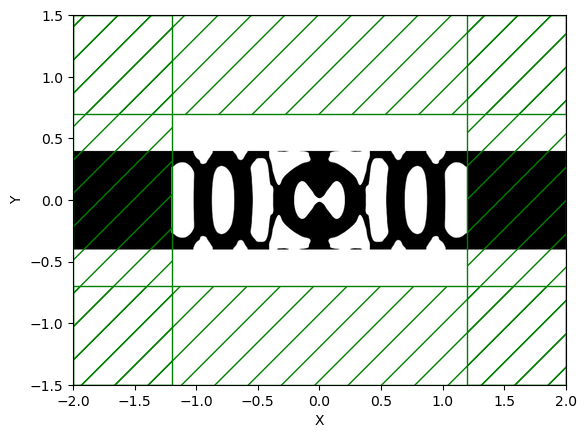

In [8]:
opt.plot2D(show_sources=False)

In [6]:
plt.figure()
for i in range(1, len(his) // 20 + 1):
    plt.axvline(x=i * 20, color='purple', linestyle='--')
plt.plot(his, "o-")
plt.xlabel("Iteration")
plt.ylabel("FOM")
plt.grid(True)
plt.savefig(f"figure/fom_history.png")
plt.close()